In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from collections import Counter
%matplotlib inline
from statannot import add_stat_annotation

# Read quantitative microbiome data

In [2]:
# Average cell count (per gram of frozen feces)
df_facs = pd.read_excel('supp/41586_2017_BFnature24460_MOESM2_ESM.xlsx',sheet_name='Supplementary Table S5')
df_facs = df_facs[['Individual','Health status','Average cell count (per gram of fresh feces)','Average cell count (per gram of frozen feces)']]
df_facs.columns = ['SubjectID','Group','FACS_fresh','FACS_frozen']
df_facs.head()

/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,SubjectID,Group,FACS_fresh,FACS_frozen
0,SC01,Healthy,1.971575e+11,1.897660e+11
1,SC02,Healthy,2.182101e+11,1.484284e+11
2,SC03,Healthy,1.259898e+11,1.173566e+11
3,SC04,Healthy,NaN,1.527821e+11
4,SC05,Healthy,1.269543e+11,1.059558e+11


# Read metadata

In [3]:
df_meta = pd.read_csv('qiime2_output/SraRunTable.txt')
df_meta = df_meta[['Run','sample_name']]
df_meta.columns = ['Run','SubjectID']
df_meta = pd.merge(df_meta, df_facs, left_on='SubjectID', right_on='SubjectID', how='inner').set_index('Run')
df_meta.head()

,SubjectID,Group,FACS_fresh,FACS_frozen
Run,,,,
ERR2015047,SC01,Healthy,1.971575e+11,1.897660e+11
ERR2015048,SC02,Healthy,2.182101e+11,1.484284e+11
ERR2015049,SC03,Healthy,1.259898e+11,1.173566e+11
ERR2015050,SC04,Healthy,NaN,1.527821e+11
ERR2015051,SC05,Healthy,1.269543e+11,1.059558e+11


In [4]:
print("# frozen data = %d, # fresh data = %d" % (len(df_meta[df_meta.FACS_frozen.notnull()]), len(df_meta[df_meta.FACS_fresh.notnull()])))

# frozen data = 135, # fresh data = 39


# Compute oral bacterial fraction

## read taxonomy

In [5]:
df_tax = pd.read_csv('qiime2_output/taxonomy.tsv', sep="\t").rename({'Feature ID':'ASV'}, axis=1)
df_tax = df_tax[df_tax.Taxon.str.contains('d__Bacteria')]
df_tax = df_tax[~(df_tax.Taxon.str.contains('Chloroplast') | df_tax.Taxon.str.contains('Mitochondria'))]
df_tax['LowestTaxonomy'] = [t.split(';')[-1].strip() for t in df_tax.Taxon]
df_tax.head()

,ASV,Taxon,Confidence,LowestTaxonomy
0,f5f5e0da89730462abaf6301a9557193,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.997650,g__Faecalibacterium
1,99deb3c5ecb022ec05609ebd1112a557,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,1.000000,g__Bacteroides
2,263e41ea2c25dc87bd2ff5910cf30d40,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.854105,g__Agathobacter
3,59777186ad2e0947e97615b5d6225136,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.998053,g__Faecalibacterium
4,8e175abe6a746b8f33bae9cd7c8192bb,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.999072,g__Faecalibacterium


## Read count data (filter out samples with less than 1000 reads)

In [7]:
df_count = pd.read_csv('qiime2_output/feature-table/feature-table.from_biom.txt', sep="\t", index_col=0, skiprows=[0])
df_count = df_count.loc[df_tax['ASV']].T
sample_ids_w_suff_reads = list(df_count.sum(axis=1)[df_count.sum(axis=1)>=1000].index)
df_count = df_count.loc[set(df_meta.index).intersection(set(sample_ids_w_suff_reads))]
df_count = df_count.loc[:, (df_count != 0).any(axis=0)]
print("minimum total count = %d" % df_count.sum(axis=1).min())
df_relabun = df_count.div(df_count.sum(axis=1), axis=0)

df_blast_HMPv35oral = pd.read_csv("qiime2_output/asv-sequences/blast_HMPv35oral/blast_HMPv35oral_p100.txt", sep="\t", comment="#", header=None)
df_blast_HMPv35oral.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']
df_oral = df_relabun[set(df_relabun.columns).intersection(set(df_blast_HMPv35oral.query_accver))].sum(axis=1).to_frame().rename({0:'OralFrac'}, axis=1)

df_meta_oral = pd.merge(df_meta, df_oral, left_index=True, right_index=True, how='inner')
df_meta_oral['log10_OralFrac'] = np.log10(df_meta_oral['OralFrac'])
df_meta_oral['log10_FACS_fresh'] = np.log10(df_meta_oral['FACS_fresh'])
df_meta_oral['log10_FACS_frozen'] = np.log10(df_meta_oral['FACS_frozen'])
df_meta_oral.head()

minimum total count = 7686


/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,SubjectID,Group,FACS_fresh,FACS_frozen,OralFrac,log10_OralFrac,log10_FACS_fresh,log10_FACS_frozen
ERR2015047,SC01,Healthy,1.971575e+11,1.897660e+11,0.000826,-3.083099,11.294813,11.278218
ERR2015048,SC02,Healthy,2.182101e+11,1.484284e+11,0.101783,-0.992326,11.338875,11.171517
ERR2015049,SC03,Healthy,1.259898e+11,1.173566e+11,0.001470,-2.832611,11.100336,11.069507
ERR2015050,SC04,Healthy,NaN,1.527821e+11,0.000000,-inf,NaN,11.184073
ERR2015051,SC05,Healthy,1.269543e+11,1.059558e+11,0.000304,-3.516720,11.103647,11.025125


all data, n = 97, slope = -0.30, r = -0.41, P = 0.000026


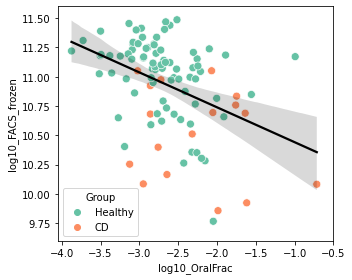

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))

df2_meta_oral = df_meta_oral[df_meta_oral.OralFrac>0]
_ = sns.scatterplot(x="log10_OralFrac", y="log10_FACS_frozen", data=df2_meta_oral, hue='Group', palette='Set2', s=64, ax=ax)
_ = sns.regplot(x="log10_OralFrac", y="log10_FACS_frozen", data=df2_meta_oral, scatter=False, color='k', ax=ax)
slope, intercept, r_value, p_value, std_err = stats.linregress(df2_meta_oral['log10_OralFrac'], df2_meta_oral['log10_FACS_frozen'])
print('all data, n = %d, slope = %2.2f, r = %2.2f, P = %2.6f'%(len(df2_meta_oral), slope, r_value, p_value))
_ = ax.set_xlim([-4.05, -0.5])
_ = ax.set_ylim([9.6, 11.6])

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("Vandeputte_oral_vs_load.svg", dpi=600)

In [9]:
Counter(df2_meta_oral.Group)

Counter({'Healthy': 80, 'CD': 17})

In [10]:
p_value

2.6299366763698984e-05

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Healthy v.s. CD: Kruskal-Wallis paired samples, P_val=2.393e-02 stat=5.100e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Healthy v.s. CD: Kruskal-Wallis paired samples, P_val=8.207e-06 stat=1.989e+01


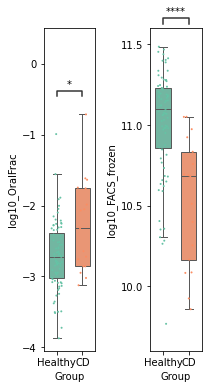

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(3,5.5))

df2_meta_oral = df_meta_oral[df_meta_oral.OralFrac>0]

# oral cavity
_ = sns.boxplot(y="log10_OralFrac", x="Group", data=df2_meta_oral, width=.6, ax=ax[0], order=['Healthy','CD'], palette='Set2', linewidth=1, showfliers=False)
_ = sns.stripplot(y="log10_OralFrac", x="Group", data=df2_meta_oral, size=2, color=".3", linewidth=0, ax=ax[0], jitter=0.2, palette='Set2', dodge=True, order=['Healthy','CD'])
_ = add_stat_annotation(ax[0], data=df2_meta_oral, y="log10_OralFrac", x="Group", order=['Healthy','CD'],
                        comparisons_correction=None,
                        box_pairs=[("Healthy","CD")],
                        test='Kruskal', text_format='star', loc='outside', verbose=1)
_ = ax[0].set_ylim([-4.05,0.5])
_ = ax[0].set_yticks([-4,-3,-2,-1,0])

# microbial load
_ = sns.boxplot(y="log10_FACS_frozen", x="Group", data=df2_meta_oral, width=.6, ax=ax[1], order=['Healthy','CD'], palette='Set2', linewidth=1, showfliers=False)
_ = sns.stripplot(y="log10_FACS_frozen", x="Group", data=df2_meta_oral, size=2, color=".3", linewidth=0, ax=ax[1], jitter=0.2, palette='Set2', dodge=True, order=['Healthy','CD'])
_ = add_stat_annotation(ax[1], data=df2_meta_oral, y="log10_FACS_frozen", x="Group", order=['Healthy','CD'],
                        comparisons_correction=None,
                        box_pairs=[("Healthy","CD")],
                        test='Kruskal', text_format='star', loc='outside', verbose=1)
_ = ax[1].set_ylim([9.6,11.6])
_ = ax[1].set_yticks([10,10.5,11,11.5])

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("Vandeputte2017Nature_oral_box_strip_plot.svg", dpi=600)